In [ ]:
import pandas as pd
import numpy as np
import string
from tqdm import tqdm
import time
import gc
import plotly.express as px
import os 
import networkx as nx
import pickle
import plotly.graph_objects as go
from datetime import datetime
from sknetwork.visualization import svg_graph, svg_bigraph
from IPython.display import SVG,display
from sknetwork.data import from_edge_list
from cairosvg import svg2png
from math import sqrt
from scipy.stats import bootstrap

In [ ]:
categories = ['Sports',
 'People & Blogs',
 'Howto & Style',
 'News & Politics',
 'Autos & Vehicles',
 'Travel & Events',
 'Film & Animation',
 'Entertainment',
 'Music',
 'Nonprofits & Activism',
 'Pets & Animals',
 'Science & Technology',
 'Comedy',
 'Gaming',
 'Education']

Given the size of the dataset. We saved the data in two formats that are useful and will be used throught this notebook. 
- We first saved the data into chunks, extracted only the relevant columns and also turned "tags" column from string to set.
- We also saved the network version of the dataset for each month and category.
This files helped us save a lot of time while doing the analysis.

In [ ]:
def tags_to_set(row):
  if row!="":
    return set([s.translate(str.maketrans('', '', string.punctuation)) for s in row.lower().split(",")]) 
  else:
    return {}

In [ ]:
import gc
categories = ["Entertainment","Gaming","News & Politics","Music"]
for category in categories:
  df_category = pd.DataFrame()
  category_path1 = f"./category_data/{category}_with_id_title_1.json"
  category_path2 = f"./category_data/{category}_with_id_title_2.json"

  # Read each processed chunk, create edge dictionaries 
  print(category)
  idx = 0
  for json_file in tqdm.tqdm([fname for fname in os.listdir("data_chunks/") if fname.endswith('.json') and fname.startswith("data_title")]):
    df_json = pd.read_json(os.path.join("data_chunks",json_file), compression="infer")
    df_json = df_json[df_json["categories"] == category]
    df_json = df_json.drop(columns=["categories"])
    df_category = pd.concat([df_category,df_json])
    idx += 1
    if idx==73:
      df_category.to_json(category_path1) 
      del df_category
      gc.collect()
      df_category = pd.DataFrame()
  df_category.to_json(category_path2) 

In [ ]:
categories = ['Sports',
 'People & Blogs',
 'Howto & Style',
 'Autos & Vehicles',
 'Travel & Events',
 'Film & Animation',
 'Nonprofits & Activism',
 'Pets & Animals',
 'Science & Technology',
 'Comedy',
 'Education']
 
for category in categories:
  df_category = pd.DataFrame()
  category_path = f"./category_data/{category}_with_id_title.json"

  print(category)
  idx = 0
  for json_file in tqdm.tqdm([fname for fname in os.listdir("data_chunks/") if fname.endswith('.json') and fname.startswith("data_title")]):
    df_json = pd.read_json(os.path.join("data_chunks",json_file), compression="infer")
    df_json = df_json[df_json["categories"] == category]
    df_json = df_json.drop(columns=["categories"])
    df_category = pd.concat([df_category,df_json])
  df_category.to_json(category_path) 

In [ ]:
def get_edges(df,edges):
  for i, row in df.iterrows():
    tags = row["tags"]
    pairs = list(itertools.combinations(tags,2))
    for pair in pairs:
      # Since undirected, all pairs contain the tag with smaller lexicographic order at the first index
      key_value = (pair[0],pair[1]) if pair[0]<pair[1] else (pair[1],pair[0])
      if key_value in edges.keys():
        edges[key_value] = edges[key_value] + 1
      else:
        edges[key_value] = 1

In [ ]:
def get_monthly_graph(x,category):
  upload_date = x["upload_date"].iloc[0]
  dir_path = f"./category_data/{category}"
  
  edges = {}
  if os.path.exists(f"{dir_path}/{category}_{upload_date}.pkl"):
    with open(f"{dir_path}/{category}_{upload_date}.pkl","rb") as pkl_file:
      edges = pkl.load(pkl_file)
  # add edges from new chunk to the existing dictionary created using previous chunks
  get_edges(x,edges)

  with open(f"{dir_path}/{category}_{upload_date}.pkl","wb") as pkl_file:
    pkl.dump(edges, pkl_file, protocol=pkl.HIGHEST_PROTOCOL)
  del edges

## Distribution of Tag Counts

We analyze the number of tags each video uses to see if tags are used in general.

In [ ]:
# return the tag count
def count_t(tags):
  return len(tags)

To find the tag counts, we visit every chunk, and add the tag count information to a global dictionary.

In [ ]:
# For each category save counts dict
counts =dict()
for category in categories:
  counts[category] = dict()

for json_file in tqdm.tqdm([fname for fname in os.listdir("data_chunks/") if fname.endswith('.json') and not fname.startswith("data_title")]):
  df = pd.read_json("data_chunks/"+json_file)
  df["count"] = df["tags"].apply(count_t)
  for k, gp in df.groupby("categories"):
    for count in list(gp["count"]):
      counts[k][count] = counts[k].get(count,0) + 1

# combine category dictionary to a total one
total_dict = counts[categories[0]]

for category in counts:
  if category == categories[0]:
    continue

  for count in counts[category].keys():
    total_dict[count] = total_dict.get(count,0) + counts[category][count]
    
total_dict_df = pd.DataFrame.from_dict(total_dict,"index")

In [ ]:
fig = px.bar(total_dict_df, x=total_dict_df.index, y=0, title="Distribution of Tag Counts", labels={'index': 'Tag Count', "0":'Number of Videos'})
fig.show()

## Timeline of Tag Counts

We now analyse how number of tags used change with time.
We use a similar approach as above, only with upload date information this time.

In [ ]:
dates_dict = dict()
for json_file in tqdm.tqdm([fname for fname in os.listdir("data_chunks/") if fname.endswith('.json') and not fname.startswith("data_title")]):
  df = pd.read_json("data_chunks/"+json_file)
  df["count"] = df["tags"].apply(count_t)
  df["year"] = df["upload_date"].str.slice(0,4)

  for k, gp in df.groupby("year"):
    for count in list(gp["count"]):
      temp_dict = dates_dict.get(k,dict())
      dates_dict[k] = temp_dict
      dates_dict[k][count] = dates_dict[k].get(count,0) + 1

In [ ]:
dates_df = pd.DataFrame.from_dict(dates_dict,"index")
dates_df = dates_df.fillna(0)
cols = list(dates_df.columns)

In [ ]:
def get_mean(row):
  sum = 0
  c = 0
  for col in cols:
    c += row[col]
    sum += col * row[col]
  return sum / c

def get_total_vid(row):
  sum = 0
  for col in cols:
    sum += row[col]
  return sum


In [ ]:
dates_df["mean"] = dates_df.apply(get_mean, axis = 1)
dates_df["Number of Videos"] = dates_df.apply(get_total_vid, axis = 1)
dates_df = dates_df.sort_index()

In [ ]:
import plotly.express as px
fig = px.bar(dates_df, x=dates_df.index, y="mean", title="Timeline of Tag Counts", labels={'index': 'Year', "mean":'Average Number of Tags'},hover_data=["Number of Videos"])
fig.show()

## Tag Behaviour Through Time

We now extract the usage information of each significant tag on each month. We only consider the tags that are used in more videos than the 85th percentile to eliminate noises. Info of each tag is extracted as a boolean array over the months with True values representing the usage in the corresponding month and False representing the absence.

In [ ]:
max_date = "2019-10-01"

def diff_month(d1, d2):
  d1 = datetime.strptime(d1, '%Y-%m-%d')
  d2 = datetime.strptime(d2, '%Y-%m-%d')
  return (d1.year - d2.year) * 12 + d1.month - d2.month

def store_living_tags(living_tags,current_usage,upload_date):
  percentile = np.percentile(list(current_usage.values()),85) 
  for tag in current_usage:
    if current_usage[tag]<percentile:
      continue
    if tag not in living_tags:
      living_tags[tag]= {upload_date:np.full(diff_month(max_date,upload_date)+1, False)}
      living_tags[tag][upload_date][0] = True
    else: 
      prev_date = list(living_tags[tag].keys())[0]
      living_tags[tag][prev_date][diff_month(upload_date,prev_date)] = True

def find_tag_usage_monthly(monthly_df,living_tags):
  upload_date = monthly_df["upload_date"].iloc[0] 
  if diff_month(upload_date,max_date)>0:
    return
  usage_dict = {}

  for i, row in monthly_df.iterrows():
    for tag in row["tags"]:
      usage_dict[tag] = usage_dict.get(tag,0)+1
  store_living_tags(living_tags,usage_dict,upload_date)
  if upload_date.split("-")[-2]=="01":
    print(upload_date)

def merge_two_living_tags(living_tags1,living_tags2): ## For big categories, data is separated into two parts that need to be merged
  living_tags1_keys = set(living_tags1.keys())
  living_tags2_keys = set(living_tags2.keys())

  intersection = living_tags2_keys.intersection(living_tags1_keys)
  merged_dict = {}

  for tag in living_tags1_keys.union(living_tags2_keys):
    if tag in intersection:
      upload_date1 = list(living_tags1[tag].keys())[0]
      upload_date2 = list(living_tags2[tag].keys())[0]
      diff_start_month = diff_month(upload_date1,upload_date2)

      if diff_start_month>=0:
        merged_dict[tag] = {upload_date1: np.concatenate([np.full(diff_start_month, True),np.logical_or(living_tags1[tag],living_tags2[tag][upload_date2][diff_start_month:])])}
      else:
        merged_dict[tag] = {upload_date2: np.concatenate([np.full(abs(diff_start_month), True),np.logical_or(living_tags2[tag],living_tags1[tag][upload_date1][abs(diff_start_month):])])}
    else:
      if tag in living_tags1_keys:
        merged_dict[tag] = living_tags1[tag]
      else:
        merged_dict[tag] = living_tags2[tag]
  return merged_dict

Now we can extract the usage information of each tag on each month:

In [ ]:
import gc
def get_living_tags(categories):

  for category in categories:
    print(category)
    try:
      df = pd.read_json(f"category_data/{category}.json")
      living_tags = {}
      df.groupby("upload_date").apply(find_tag_usage_monthly,living_tags)
    
      del df
      gc.collect()

      with open(f"{category}_binary_usage.pkl","wb") as result_file:
        pkl.dump(living_tags,result_file)
    except:

      living_tags1 = {}
      df_json = pd.read_json(f"category_data/{category}_1.json")
      df_json.groupby("upload_date").apply(find_tag_usage_monthly,living_tags1)
      del df_json
      gc.collect()

      living_tags2 = {}
      df_json = pd.read_json(f"category_data/{category}_2.json")
      df_json.groupby("upload_date").apply(find_tag_usage_monthly,living_tags2)
      
      del df_json
      gc.collect()

      print("merge started")
      living_tags = merge_two_living_tags(living_tags1,living_tags2)
      print("merge done")

      with open(f"{category}_binary_usage.pkl","wb") as result_file:
        pkl.dump(living_tags,result_file)

In [ ]:
get_living_tags(['Sports',
 'People & Blogs',
 'Howto & Style',
 'Autos & Vehicles',
 'Travel & Events',
 'Film & Animation',
 'Nonprofits & Activism',
 'Pets & Animals',
 'Science & Technology',
 'Comedy',
 'Education',
 'Entertainment','Gaming','News & Politics','Music'])

Now that we have the usage data, we can visualize the lifespan of tags:

Autos & Vehicles
Comedy
Education
Entertainment
Film & Animation
Gaming
Howto & Style
Music
News & Politics
Nonprofits & Activism
People & Blogs
Pets & Animals
Science & Technology
Sports
Travel & Events


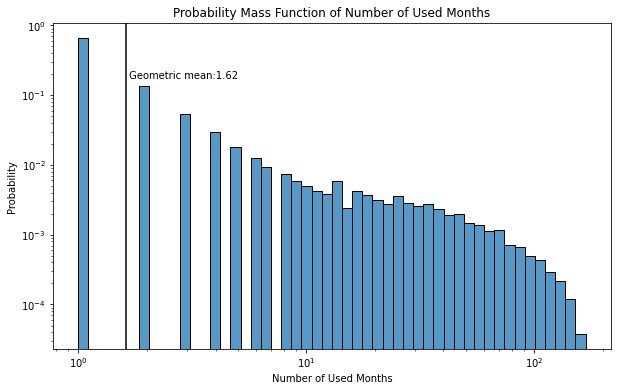

In [ ]:
live_months = []
for category in sorted(categories):
  with open(f"{category}_binary_usage.pkl","rb") as result_file:
    
    tag_usage = pkl.load(result_file) 
    for tag in tag_usage:
      upload_date = list(tag_usage[tag].keys())[0]
      boolean_usage = tag_usage[tag][upload_date]
      live_months.append(np.diff(np.where(np.concatenate(([boolean_usage[0]],boolean_usage[:-1] != boolean_usage[1:],[True])))[0])[::2])
    print(category)

number_of_live_months = np.concatenate(live_months)

plt.figure(figsize=(10,6))
sns.histplot(number_of_live_months,bins=50,log_scale=(True,True),stat='probability')
plt.axvline(x=gmean(number_of_live_months), color='black', label="geometric mean")
plt.text(x=gmean(number_of_live_months),y=0.17,s=f" Geometric mean:{gmean(number_of_live_months):.2f}")
plt.xlabel('Number of Used Months')
plt.ylabel('Probability')
plt.title("Probability Mass Function of Number of Used Months")
plt.show()

In addition to the statistics for the general population, we can also extract tag-wise results for some tags that gain periodic usage to show that tags indeed follow the world wide trends. For this, we first define a method to find usage in a single month and use it on each month:

In [ ]:
import gc

upload_periods = pd.to_datetime(np.arange(np.datetime64("2005-05"), np.datetime64("2019-11"), np.timedelta64(1, 'M')))
upload_periods = [str(period.strftime('%Y-%m-%d')) for period in upload_periods]

def find_tag_usage_per_month(monthly_df,usage_dict,tag):
  upload_date = monthly_df["upload_date"].iloc[0]
  if upload_date not in usage_dict:
    usage_dict[upload_date]=len(monthly_df[monthly_df["tags"].map(set([tag]).issubset)])
  else:
    usage_dict[upload_date]+=len(monthly_df[monthly_df["tags"].map(set([tag]).issubset)])

def find_total_usage(categories,tag):
  tag_usage = {}
  for category in categories:
    if os.path.exists(f"category_data/{category}_1.json"):
      category_data = pd.read_json(f"category_data/{category}_1.json")
      category_data.groupby("upload_date").apply(find_tag_usage_per_month,tag_usage,tag)
      print(f"{category}_1")
      del category_data
      gc.collect()
      category_data = pd.read_json(f"category_data/{category}_2.json")
      category_data.groupby("upload_date").apply(find_tag_usage_per_month,tag_usage,tag)
      print(f"{category}_2")
    else:
      category_data = pd.read_json(f"category_data/{category}.json")
      category_data.groupby("upload_date").apply(find_tag_usage_per_month,tag_usage,tag)
      print(f"{category}")
    del category_data
    gc.collect()
  return tag_usage

In [ ]:
halloween_usage = find_total_usage(categories,"halloween")
olympic_usage = find_total_usage(categories,"olympics")

Now let's investigate the trajectories of "halloween" and "olympics":

In [ ]:
import plotly.express as px
halloween_df = pd.DataFrame(data=halloween_usage.items(),columns=["Date","Usage"])
halloween_df = halloween_df.set_index("Date")
fig = px.bar(halloween_df,x=halloween_df.index,y="Usage",
             title='Usage Statistics of Tag "halloween"',
             labels={'index': 'Number Of Popular Months', "Usage":'Number of Videos using tag "halloween"'}, orientation='v')
fig.show()
fig.write_html("halloween_usage.html")


In [ ]:
import plotly.express as px
olympics_df = pd.DataFrame(data=olympic_usage.items(),columns=["Date","Usage"])
olympics_df = olympics_df.set_index("Date")
fig = px.bar(olympics_df,x=olympics_df.index,y="Usage",
             title='Usage Statistics of Tag "olympics"',
             labels={'index': 'Number Of Popular Months', "Usage":'Number of Videos using tag "olympics"'}, orientation='v')
fig.show()
fig.write_html("olympic_usage.html")

## Popularity Analysis

Popular tags can provide useful information about the tag behaviour in YouTube. So, we propose a method to find popular tags, inspired by https://stackoverflow.com/a/826509. For each category, we investigate the monthly usage and compare it to the previous months by standardizing the current usage value with previous usage mean and std:
$$z-score=\frac{(usage-\mu)}{\sigma}$$
Then, we identify the tags with highest 15 z-scores as popular for each month and then update the previous usage values with the current usage. We only consider the tags with usage more then 90th percentile each month to eliminate biases. 

In [ ]:
def update_previous_usage(prev_usages,tag_usages,current_month,month_limit=6):
  for tag,usage in tag_usages.items():
    if tag in prev_usages.keys():
      dates, usages = prev_usages[tag]
      usages.append(usage)
      dates.append(current_month)
    else:
      prev_usages[tag] = ([current_month],[usage])
  new_usage_history = {}
  for tag,stats in prev_usages.items():
      dates, usages = stats 
      avaiable_dates = np.where(np.array(dates)>current_month-month_limit)[0]
      dates = np.array(dates)[avaiable_dates].tolist()
      usages = np.array(usages)[avaiable_dates].tolist()
      if len(dates)>0:
        new_usage_history[tag] = (dates,usages)
  return new_usage_history
  
def calculate_zscores(prev_usages,tag_usage):
  zscores = {}

  if len(prev_usages)!=0:
    default_mean = np.mean([np.mean(usages) for (dates, usages) in prev_usages.values()])
    default_std = np.mean([np.std(usages) for (dates, usages) in prev_usages.values()])
  else:
    default_mean=0
    default_std=1
  if default_std==0:
    default_std = 1
  percentile = np.percentile(list(tag_usage.values()),90)
  for tag,usage in tag_usage.items():
    avg, std = default_mean, default_std
    if tag in prev_usages:
      _, usages =  prev_usages[tag]
      avg = np.mean(usages) 
      std = np.std(usages) 
    zscore = (usage-avg)/std if std!=0 else (usage-avg)/default_std
    zscores[tag] = zscore  
    if usage<percentile:
      zscores[tag] = 0
  return dict(sorted(zscores.items(), key=lambda item: item[1],reverse=True))

We also store the details of how many months the popular tags remain popular for further analysis:

In [ ]:
def store_viral_events(viral_events,zscores,popular_tags,upload_date):

  for tag in popular_tags:
    if tag not in viral_events:
      viral_events[tag]= {"history":[],"newest":upload_date}
    elif viral_events[tag]["newest"] == "Finished":
      viral_events[tag]["newest"] = upload_date
  for tag in viral_events.keys():
    if (tag not in zscores or zscores[tag]<-1.96) and viral_events[tag]["newest"]!="Finished":
      viral_events[tag]["history"].append(diff_month(upload_date,viral_events[tag]["newest"]))
      viral_events[tag]["newest"] = "Finished"

In [ ]:
for category in categories:
  prev_usages = {}
  max_zscores = []
  most_viral_events = []

  viral_events = {}
  with open(f"{category}.txt","w") as result_file:
    print("*"*25+category+"*"*25)
    for ind, monthly_graph_file in enumerate(sorted(os.listdir(f"category_data/{category}/"))):
      upload_date = monthly_graph_file.split("_")[1].split(".")[0]
      with open(os.path.join(f"category_data/{category}/",monthly_graph_file),"rb") as pkl_file:
        edges = pkl.load(pkl_file)
        if len(edges)==0:
          continue
        singularized_edges = edges
        tag_usages = aggregate_tag_usage(singularized_edges)
        zscores = calculate_zscores(prev_usages,tag_usages)

        popular_tags = list(zscores.keys())[:15]
        max_zscores = max_zscores + list(zscores.values())[:15]
        most_viral_events = most_viral_events + [(upload_date,popular_tag) for popular_tag in popular_tags]

        sorted_indices = np.array(max_zscores).argsort()
        max_zscores = np.array(max_zscores)[sorted_indices][-100:].tolist()[::-1]
        most_viral_events = np.array(most_viral_events)[sorted_indices][-100:].tolist()[::-1]
        decreasing_popular_tags = [tag for tag in list(zscores.keys()) if tag in prev_usages.keys()][-15:]

        prev_usages = update_previous_usage(prev_usages,tag_usages,ind)
        store_viral_events(viral_events,zscores,popular_tags,upload_date)

        print(category,upload_date)
        print("Popular:",popular_tags)
        print("Decreasing popular:",decreasing_popular_tags)
        print("*"*25)

        print(category,upload_date,file=result_file)
        print("Popular:",popular_tags,file=result_file)
        print("Decreasing popular:",decreasing_popular_tags,file=result_file)
        print("*"*25,file=result_file)
    print(most_viral_events)
    print(max_zscores)
    print(most_viral_events,file=result_file)
    print(max_zscores,file=result_file)
  with open(f"{category}.pkl","wb") as result_file:
    pkl.dump(viral_events,result_file)    

*************************Entertainment*************************
Entertainment 2005-07-01
Popular: ['stockshot', 'culture', 'tradition', 'folklore', 'music', 'muziek', 'zealand', 'maoiri', 'dance', 'nieuw', 'zeeland', 'dansen', 'dans', 'new', 'craftmanship']
Decreasing popular: []
*************************
Entertainment 2005-09-01
Popular: ['code', 'iptv', 'comedy', 'hack', 'tech', 'hak5', 'mod', 'vidcast']
Decreasing popular: []
*************************
Entertainment 2005-10-01
Popular: ['the portuguese kids', 'the portuguese kids live', 'portuguese', 'coming out to parents', 'portuguese kid', 'portuguese kid shows', 'portuguese problems', 'portugese kids', 'coming out of the closet', 'portuguese comedy', 'gay portuguese', 'coming out as portuguese', 'parents reaction', 'portuguese kids gay', 'portuguese kids live show']
Decreasing popular: ['code', 'iptv', 'comedy', 'hack', 'tech', 'hak5', 'mod', 'vidcast', 'cobaltgruv', 'crazy', 'stunts']
*************************
Entertainment 2005

## Popular Event Statistics

With the popularity information, we now can investigate the evolution of popular tags through time:

In [ ]:
with open("trend_data.json","rb") as json_file:  
  popular_events = json.load(json_file)    ## load the popular tags

We now visualize the number of months the tags remain popular:

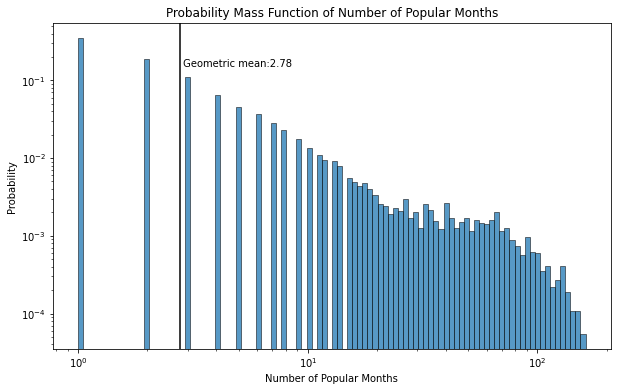

In [ ]:
number_of_popular_months = []
for category in sorted(categories):
  with open(f"{category}.pkl","rb") as result_file:
    viral_events = pkl.load(result_file) 
    number_of_popular_months_per_category = sum([viral_events[tag]["history"] for tag in viral_events],[])
    number_of_popular_months_per_category = [x for x in number_of_popular_months_per_category if x!=0]
    number_of_popular_months  = number_of_popular_months + number_of_popular_months_per_category

plt.figure(figsize=(10,6))
sns.histplot(number_of_popular_months,bins=100,log_scale=(True,True),stat='probability')
plt.axvline(x=gmean(number_of_popular_months), color='black', label="geometric mean")
plt.text(x=gmean(number_of_popular_months),y=0.15,s=f" Geometric mean:{gmean(number_of_popular_months):.2f}")
plt.xlabel('Number of Popular Months')
plt.ylabel('Probability')
plt.title("Probability Mass Function of Number of Popular Months")
plt.show()

We can do the same analysis on each category to observe categorical differences:

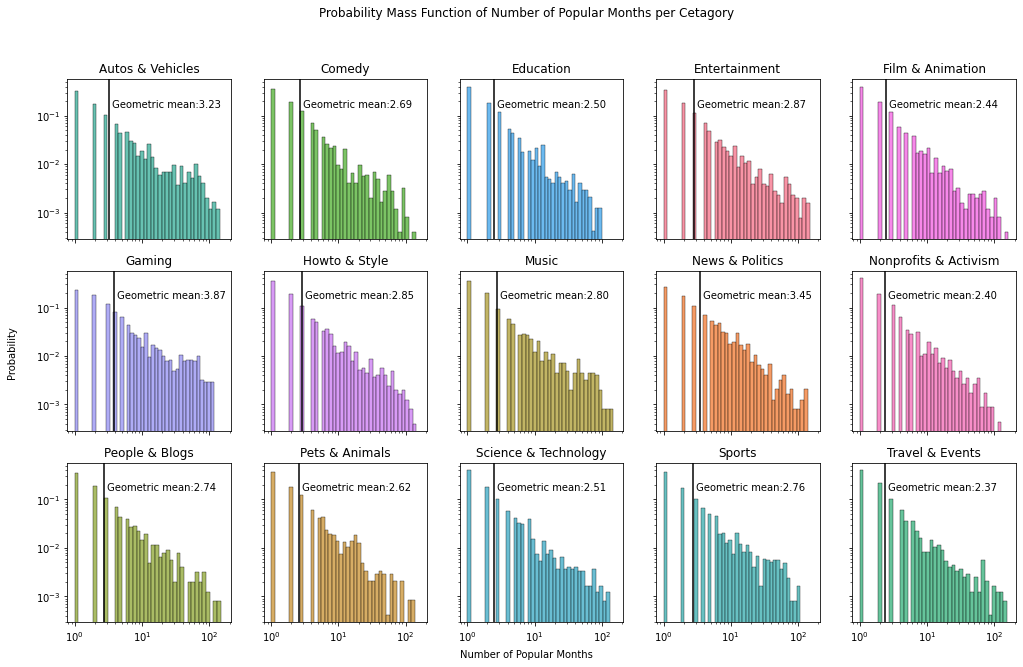

In [ ]:
fig,axes =  plt.subplots(3,5,sharex=True,sharey=True,figsize=(17,10))

index = 0
pal1 = sns.color_palette("husl", 15)
random.shuffle(pal1)

for category in sorted(categories):
  with open(f"{category}.pkl","rb") as result_file:
    viral_events = pkl.load(result_file) 
    number_of_popular_months = sum([viral_events[tag]["history"] for tag in viral_events],[])
    number_of_popular_months = [x for x in number_of_popular_months if x!=0]
     
    ax = axes[int(index/5),index%5]
    sns.histplot(number_of_popular_months,bins=40,log_scale=(True,True),ax=ax,stat='probability',color=pal1[index])
    
    index+=1
    ax.axvline(x=gmean(number_of_popular_months), color='black', label="geometric mean")
    ax.text(x=gmean(number_of_popular_months),y=0.15,s=f" Geometric mean:{gmean(number_of_popular_months):.2f}")
    ax.set_title(f"{category}")
    ax.set(ylabel='')
   
fig.text(0.5, 0.08, 'Number of Popular Months', ha='center', va='center')
fig.text(0.08, 0.5, 'Probability', ha='center', va='center', rotation='vertical')
fig.suptitle("Probability Mass Function of Number of Popular Months per Cetagory")
#fig.tight_layout()
fig.show()

## Video-tag relation to Tag Network

We give an example tag network to explain the characteristics of the tag network and how it is constructed:

In [ ]:
def display_tag_graph():  
  examples = pd.DataFrame(
    {'title': ['Messi Highlights',
      'Argentina had the answer for Serbia!',
      "USA v Argentina - Men's Basketball Semi-Final"],
     'tags': [["messi","world cup","argentina","barcelona","sports"],
      ["basketball","argentina","world cup 2019","world cup","serbia"],
      ["usa","argentina","basketball", "athens 2004","replay","sports"]]})

  tags = set()
  tag_edges = {}
  bi_edges = []
  labels = []
  video_titles = []
  for i,example in examples.iterrows():
    video_titles.append(example.title)
    for tag in example.tags:
      tags.add(tag)
      bi_edges.append((example.title,tag))
      labels.append(i)
      for tag_rel in example.tags:
        if tag!=tag_rel:
          key = (tag_rel,tag) if tag_rel<tag else (tag,tag_rel)
          tag_edges[key] = tag_edges.get(key,0) + 1
      
  graph = from_edge_list(bi_edges, bipartite=True)
  biadjacency = graph.biadjacency
  names = graph.names
  names_col = graph.names_col
  image = svg_bigraph(biadjacency,names_row=names, names_col=names_col,labels_row=[0,1,2],label_colors=["#6495ed","#2f4f4f","#ffdead"])
  display(SVG(image))
  svg2png(bytestring=image,write_to='bipartite.png')

  edges = [(edge[0],edge[1],weight) for edge,weight in tag_edges.items()]
  graph = from_edge_list(edges)
  adjacency = graph.adjacency
  names = graph.names

  image = svg_graph(adjacency,names=list(names),display_edge_weight=True)
  display(SVG(image))
  svg2png(bytestring=image,write_to='tag.png')

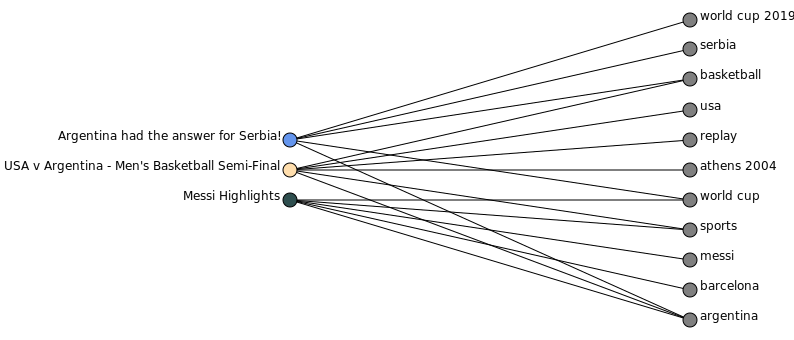

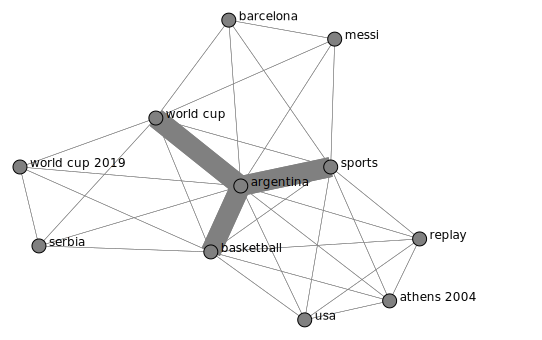

In [ ]:
display_tag_graph()

## Centrality Analysis

To see if we can see popularity in the network graphs in terms of centrality, we calculate the centrality for each tag for a five month range, with the month of the popularity in the middle.

In [ ]:
f = open('trend_data.json')
POPULAR_TAGS = json.load(f)

In [ ]:
def get_category_data(category):
  df = pd.read_json(f"./category_data/{category}.json")
  df["upload_date"] = df["upload_date"].progress_apply(pd.to_datetime)
  return df

In [ ]:
# load the graph for given category and date
def get_category_date_graph(category, year, month):
  month_str = str(month) if month>=10 else ("0"+str(month))
  name = f"{category}_{str(year)}-{month_str}-01.pkl"
  with open(os.path.join(f"category_data/{category}/",name),"rb") as pkl_file:
      edges = pickle.load(pkl_file)

  g = nx.Graph()

  for (node1, node2), weight in edges.items():
    g.add_edge(node1, node2, weight = weight)

  return g

In [ ]:
# return a timeframe of 5 months
def get_timeframe(trend_month):
  if trend_month[1] <= 2:
    min_month = [trend_month[0]-1, (trend_month[1] - 3) % 12 + 1]
  else:
    min_month = [trend_month[0], trend_month[1] - 2]

  if trend_month[1] >= 10:
    max_month = [trend_month[0]+1, (trend_month[1] + 1) % 12 + 1]
  else:
    max_month = [trend_month[0], trend_month[1] + 2]

  date_range = pd.date_range(f'{min_month[0]}-{min_month[1]}-01',f'{max_month[0]}-{max_month[1]}-01',freq='MS')

  return date_range

In [ ]:
def degree_cent(g, topic=None):
  if topic==None:
    return nx.degree_centrality(g)

  if g.has_node(topic):
    return nx.degree_centrality(g)[topic] 
  else:
    return 0

def closeness_cent(g, topic=None):
  if topic==None:
    return nx.closeness_centrality(g)
  if g.has_node(topic):
    return nx.closeness_centrality(g, topic)
  else:
    return 0

def eigen_cent(g, topic=None):
  if topic==None:
    return nx.eigenvector_centrality(g)
  if g.has_node(topic):
    return nx.eigenvector_centrality(g)[topic] 
  else:
    return 0

def smap(f):
    return f()

In [ ]:
def get_next_month(month):
  next_month = month
  next_month[1] += 1
  if next_month[1] == 13:
    next_month[1] = 1
    next_month[0] += 1

  if next_month[0] == 2019 and trend_month[1] > 11:
    return -1
  return next_month

In [ ]:
month_list = list(POPULAR_TAGS["Sports"].keys())

We make this calculation for the top-3 most popular tags given the time it takes for the calculation measures of centralities.

In [ ]:
LENGTH = 5
diff = (LENGTH -1)//2
topk = 3

month_id = 0

for category in POPULAR_TAGS.keys():

  # keep a np array for each month, each popular tag, teach centrality measure and 5 month timeframe
  stats_p = np.full((len(month_list) - diff*2, topk, 3, LENGTH), -1.0) 

  months = POPULAR_TAGS[category]

  for month_id, month in enumerate(month_list):
    trend_month = [int(month.split("-")[0]), int(month.split("-")[1])]

    g = get_category_date_graph(category, trend_month[0], trend_month[1])
    res = [degree_cent(g), eigen_cent(g)]

    for i in range(LENGTH): 
      temp_id = month_id + i - diff
      if temp_id<diff or temp_id>=(len(month_list)-diff):
        continue
      temp_month = month_list[temp_id]

      for j,popular in enumerate(months[temp_month]["popular"][:topk]):
        which_id = LENGTH - i - 1
        stats_p[temp_id - diff][j][0][which_id] = res[0][popular] if popular in res[0].keys() else 0
        stats_p[temp_id - diff][j][1][which_id] = closeness_cent(g, popular)
        stats_p[temp_id - diff][j][2][which_id] = res[1][popular] if popular in res[1].keys() else 0


  with open(f'eigen_calc/{category}_pop.npy', 'wb') as f:
    np.save(f,stats_p) 



In [ ]:
# combine statistics for each category into one
stats_ = []
for category in categories:

  stats_p = np.load(f'eigen_calc/{category}_pop.npy')
  stats_.append(stats_p)

stats_ = np.concatenate(stats_)
stats_ = stats_.reshape(-1,3,5)

For each month related to popularity, we find the error rate using bootstraping.

In [ ]:
intervals = [[],[],[]]
for i in range(3):
  for j in range(5):
    res = bootstrap((stats_3[:,i,j],), np.mean, confidence_level=0.9,random_state=5)
    intervals[i].append(res.standard_error*2)

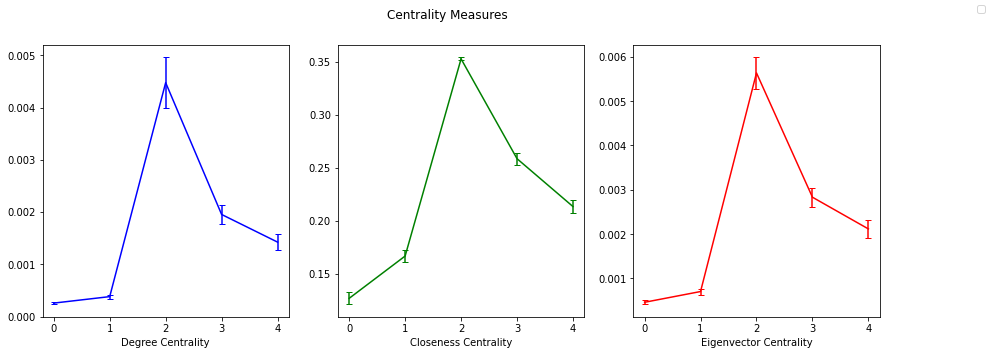

In [ ]:
x = list(range(5))

measure = ["Degree Centrality", "Closeness Centrality", "Eigenvector Centrality"]
colors = ['b', 'g', 'r']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Centrality Measures')

for i, ax in enumerate(axs):
  ax.errorbar(x, np.mean(stats_[:,i,:],axis = 0),yerr = intervals[i] , color = colors[i], capsize=3)
  ax.set(xlabel=measure[i])

fig.legend()
fig.show()

## Detect Misuse

We now focus on detecting videos with misuse. Given that misuse is related to the video content, we assume that the title represents the content of the video and therefore we take advantage of the titles of the videos in our analysis. The first thing that comes to mind may be to check the presence of the word "Trump" in the title, however, this would not take us further as videos with titles not containing Trump may still be relevant, such as "Meet Up Details / Feelings about New President!". To tackle this problem, we first find the most related tags with the tag "trump", and use those as a hint of relevance.  
We take the following approach to find relevant tags:
-  Filter out the tags whose usage is less than 90% of the population. With this approach, we only get tags that are widely used.
- For each tag, find the number of videos it is used. num_used
- For each tag, find the number of videos it is used with the tag "trump", num_used_trump.
- Ratio = num_used_trump / num_used * 100
- Take the tags with length > 2 and with ratio > 0.5

These relevant tags are checked in video title, if title does not include any of these words but includes the tag "trump", we mark it as possible misuse.

In [ ]:
# check if lowercase row contains any of the words in tags
def does_it_include(row, tags):
  l_t = row.lower()
  return 1 if any([tag in l_t for tag in tags]) else 0

In [ ]:
# For a given category and month, returns all the tags in a dictionary where values are the number of videos that tag is used.
def get_num_used(category, year, month):
  try:

    data_used = dict()

    df = pd.read_json(f"category_data/{category}_with_id_title.json")
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df = df[(df["upload_date"].dt.year == year) &(df["upload_date"].dt.month == month)]

    for i,row in df.iterrows():
      for tag in row.tags:
        data_used[tag] = data_used.get(tag,0) +1
    
  except:

    data_used = dict()

    df_json = pd.read_json(f"category_data/{category}_with_id_title_1.json")
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[df_json["upload_date"].isin(date_range)]

    for i,row in df_json.iterrows():
      for tag in row.tags:
        data_used[tag] = data_used.get(tag,0) +1

    del df_json

    df_json = pd.read_json(f"category_data/{category}_with_id_title_2.json")
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[df_json["upload_date"].isin(date_range)]
    
    for i,row in df_json.iterrows():
      for tag in row.tags:
        data_used[tag] = data_used.get(tag,0) +1

    del df_json

  

  return data_used
  

In [ ]:
# for a given network g, tag usage dictionary from get_num_used() and tag, returns the list of related tags
def get_related_tags(g, data_used, tag):

  degrees = g.degree(weight = "weight")
  threshold = np.percentile(list(dict(degrees).values()), 90)

  df = []

  ent_a_count = degrees[tag]

  for _,node1, weight in g.edges(tag, data="weight"):

    if degrees[node1] < threshold:
      continue

    data_dict = dict()

    data_dict["pmi"] = weight / (data_used[tag]) * 100
    data_dict["ent_b"] = node1

    df.append(data_dict)
  
  df = pd.DataFrame(df).sort_values(by=['pmi'],ascending=False)

  if len(df)==0:
    return [tag]

  return list(df[df["pmi"] > 0.5]["ent_b"]) + [tag] , df


In [ ]:
# For "category", in a "date_range", finds all videos that contain the "tag" in their tags
# For each these videos finds whether their titles include any of the words in "related_tags" and returns a dictionary containing these values
def get_misuse_titles(category, tag, related_tags, date_range):

  try:
    df = pd.read_json(f"category_data/{category}_with_id_title.json")
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df = df[df["upload_date"].isin(date_range)]
    df = df[df.tags.apply(lambda x: (tag in x))]
    
  except:

    df = []

    df_json = pd.read_json(f"category_data/{category}_with_id_title_1.json")
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[df_json["upload_date"].isin(date_range)]
    df_json = df_json[df_json.tags.apply(lambda x: (tag in x))]
    df.append(df_json.copy())

    del df_json

    df_json = pd.read_json(f"category_data/{category}_with_id_title_2.json")
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[df_json["upload_date"].isin(date_range)]
    df_json = df_json[df_json.tags.apply(lambda x: (tag in x))]
    df.append(df_json.copy())

    del df_json

    df = pd.concat(df)


  df["title_inc"] = df.title.apply(does_it_include, tags=related_tags)


  return df
  

In [ ]:
POPULAR_TAGS = [ ("News & Politics", "trump", 2016,11 )]

In [ ]:
# Load the related data
category, tag, year, month = POPULAR_TAGS[0]
date_range = get_timeframe([year, month])
data_used = get_num_used(category, year, month)
g = get_category_date_graph(category, year, month)

In [ ]:
# find related tags, eliminate tags with length smaller than 3
related_tags, pmi_df = get_related_tags(g, data_used, tag) 
related_tags = [x for x in related_tags if ( len(x)>2)]

In [ ]:
# Create a dataframe with the related tags and their ratio for visualization purposes
df_temp = []
for tag in related_tags:
  if tag == "trump":
    continue
  data = dict()
  data["Tag"] = tag
  data["Ratio"] = np.round(pmi_df[pmi_df["ent_b"] == tag].iloc[0].pmi,3)
  df_temp.append(data)
df_temp = pd.DataFrame(df_temp)
df_temp = df_temp.sort_values("Ratio",ascending=False)

We use [plotly](https://plotly.com/) for interactive plots.

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_temp.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df_temp.Tag, df_temp.Ratio],
               fill_color='lavender',
               align='left'))
])

fig.show()

To detect misuse, we find the videos that has the tag "trump" from other categories.

In [ ]:
other_cats = []
for i,category_2 in enumerate(categories):
    
    if category_2 == category:
      continue

    temp = get_misuse_titles(category_2, tag, related_tags, date_range)
    temp["category"] = category_2
    other_cats.append(temp)
other_cats_df = pd.concat(other_cats)

In [ ]:
#indicator whether the title has the tag "trump"
other_cats_df["title_inc_trump"] = other_cats_df.title.apply(does_it_include, tags=["trump"])

In [ ]:
# possible misuse cases
other_cats_df_misuse = other_cats_df[(other_cats_df["title_inc"]==0)]

We sample around 20% of each category and label them manually.
Our labelling results can be found [here.](https://docs.google.com/spreadsheets/d/1cK55fl4xL9sktpDxsKsMGiQ0cb6Nw_bDg4K7s_CbfGE/edit?usp=sharing)

In [ ]:
other_cats_df_misuse.groupby('category').sample(frac = 0.2).to_csv("Other Categories_Possible Misuse.csv")

In [ ]:
import plotly.express as px
data = dict(
    types=["With Tag Trump", "Related Tags in Title", "Related Tags not in Title",  "Trump in Title", "Trump not in Title"],
    parent=["", "With Tag Trump", "With Tag Trump", "Related Tags in Title" , "Related Tags in Title"],
    example=["'THE FED TO HOLD THE HANDS OF ALL U.S. BANKS'", "'Dear Electoral College'", "'TYRANNY Gameplay #02 ARCHONS - Let's Play'", "'EPIC Reactions to Trump Winning US Presidential Election'","Tackle-Buster Gator Bluefish!"],
    value=[len(other_cats_df), 
           len(other_cats_df[other_cats_df["title_inc"] == 1]), 
           len(other_cats_df[other_cats_df["title_inc"] == 0]), 
           len(other_cats_df[(other_cats_df["title_inc"] == 1) & (other_cats_df["title_inc_trump"] == 1)]),
           len(other_cats_df[(other_cats_df["title_inc"] == 1) & (other_cats_df["title_inc_trump"] == 0)])
           ])

fig = px.sunburst(
    data,
    names='types',
    parents='parent',
    values='value',
    branchvalues="total",
    hover_data={"example":True},
    
)

fig.show()

We now analyze the manual labeling results.

In [ ]:
def percentage(row):
  return row[0.0] /(row[1.0] + row[0.0] + row["N/A"])

In [ ]:
# load the labeled dataset.
labeled_dataset = pd.read_csv("./label_out/Other Categories_Possible Misuse.csv")
labeled_dataset = labeled_dataset.fillna("N/A")

# group by category
grouped = labeled_dataset.groupby(['category', 'is it related to trump? 1:yes 0:no']).size().unstack(fill_value=0)

In [ ]:
grouped["Percentage"] = grouped.apply(percentage, axis = 1)
grouped = grouped.sort_values("Percentage", ascending=False)

In [ ]:
import plotly.express as px

config = {'displaylogo': False}
default_cat = "Total"

figs =dict()

data = dict(
    label=["Related", "Misuse", "N/A"],
    count=[labeled_dataset[labeled_dataset["is it related to trump? 1:yes 0:no"] == 1.0], 
           labeled_dataset[labeled_dataset["is it related to trump? 1:yes 0:no"] == 0.0], 
           labeled_dataset[labeled_dataset["is it related to trump? 1:yes 0:no"] == "N/A"]])
fig2 = px.pie(
      data,
      names='label',
      values='count',  
      title=(f"<b> Total </b>"),   
  ).update_traces(
        name="Total", visible=False)
figs["Total"] = fig2


for category in grouped.index:
  data = dict(
    label=["Related", "Misuse", "N/A"],
    count=[grouped.loc[category][1.0], grouped.loc[category][0.0], grouped.loc[category]["N/A"]])
  fig2 = px.pie(
        data,
        names='label',
        values='count',  
        title=(f"<b>{category} </b>"),   
    ).update_traces(
         name=category, visible=False)
  figs[category] = fig2


# integrate figures per date into one figure
fig = figs[default_cat].update_traces(visible=True)
for k in figs.keys():
    if k != default_cat:
      fig.add_traces(figs[k].data)
 

# finally build dropdown menu
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": k,
                    "method": "update",
                    # list comprehension for which traces are visible
                    "args": [{"visible": [kk == k for kk in figs.keys()]},
                             {"title": (f"<b>{k} </b>")} # update
                             ]
                 
             
                }
                for k in figs.keys()
             ],
             "direction": "down", "x": 0.07, "y": 1.15, "bgcolor":'#1F2F40', 
             "bordercolor":"#1F2F40"
        }
    ]
 )

fig.update_layout(
           title={
           'x':0.5,
           'xanchor': 'center'
        })

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', 
font=dict(color='#CACFD3'))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

We now check how misused tag usage change with time.

In [ ]:
# Percentage without N/A
def percentage2(row):
  return row[0.0] /(row[1.0] + row[0.0])

In [ ]:
grouped_date = labeled_dataset.groupby(['upload_date', 'is it related to trump? 1:yes 0:no']).size().unstack(fill_value=0)

In [ ]:
grouped_date["Ratio"] = grouped_date.apply(percentage2, axis = 1)
grouped_date['Upload Date'] = grouped_date.index
grouped_date['Upload Date'] = grouped_date['Upload Date'].str.slice(0,7)

In [ ]:
grouped_date['Percentage of Videos'] = grouped_date.apply(num_vid, axis = 1)

In [ ]:
import plotly.express as px

import plotly.graph_objects as go

fig = go.Figure()

fig = px.line(grouped_date, x="Upload Date", y="Ratio", title='<b>Ratio of Misused Videos </b>', markers=True)
fig.update_layout(xaxis=dict(tickformat="%m"))
fig.update_layout(xaxis={'type': 'category'})

fig.show()